In [1]:
from pathlib import Path
import pandas as pd
from keras.layers import BatchNormalization, Dense, Input, Conv1D, Add, ELU, Flatten, MaxPooling1D
from keras.layers import GlobalAveragePooling1D, Softmax, Concatenate, Reshape, Multiply, ReLU
from keras.optimizers import SGD
from keras import activations
from keras import Model
from keras.initializers import HeNormal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from load_dataset import load_original_daic, load_labels
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.vis_utils import plot_model
import keras_dilated_nn

In [2]:
daic_AUs_train = load_original_daic("original_daic/train", "AUs")
daic_AUs_dev = load_original_daic("original_daic/dev", "AUs")
daic_AUs_test = load_original_daic("original_daic/test", "AUs")

In [3]:
# daic_AUs_dev["432"].loc[0:4999]
for i in range(5000):
    try:
        temp = daic_AUs_test["432"].loc[i].to_numpy(dtype="float32")
    except Exception:
        print(i)

In [4]:
label_path = Path("original_daic/labels")
loaded_labels = load_labels(label_path)
y_train = np.array(loaded_labels["train"])
y_dev = np.array(loaded_labels["dev"])
y_test = np.array(loaded_labels["test"])


In [5]:
AUs_train = []
AUs_dev = []
AUs_test = []
for subject_id, subject_df in daic_AUs_train.items():
    temp = subject_df.copy().loc[1000:5999].to_numpy(dtype="float32")
    AUs_train.append(temp)
for subject_id, subject_df in daic_AUs_dev.items():
    # print(subject_id)
    temp = subject_df.copy().loc[1000:5999].to_numpy(dtype="float32")
    AUs_dev.append(temp)
for subject_id, subject_df in daic_AUs_test.items():
    # print(subject_id)
    temp = subject_df.copy().loc[1000:5999].to_numpy(dtype="float32")
    AUs_test.append(temp)

In [6]:
# list1 = [np.array([12,1]), np.array([2,3])]
# list2 = [np.array([4,5]), np.array([6,7])]
# list3 = [np.array([8,9]), np.array([10,11])]
# all_lists = np.array(list1 + list2 + list3)
# print(all_lists.min(0))
# print(all_lists.ptp(0))
all_samples = AUs_train + AUs_dev + AUs_test
# all_samples = np.array(AUs_train + AUs_dev + AUs_test, dtype=object)
all_samples = np.concatenate((all_samples),)
# all_samples.shape
min_values = all_samples.min(axis=0)
ptp_ranges = all_samples.ptp(axis=0)

In [7]:
AUs_train = np.array(AUs_train)
AUs_dev = np.array(AUs_dev)
AUs_test = np.array(AUs_test)

In [8]:
norm_AUs_train = (AUs_train - min_values)/ptp_ranges
norm_AUs_dev = (AUs_dev - min_values)/ptp_ranges
norm_AUs_test = (AUs_test - min_values)/ptp_ranges

In [9]:
input_AUs = Input(shape=[5000, 20])
tdcn_dim_AUs = [128,64,256,128,64] # used in Guo's paper
# tdcn_dim_AUs = [128,128,128,128,128]
bias_initializer = HeNormal(seed=0)

In [11]:
# TDCN block for AUs
tdcn_AUs = keras_dilated_nn.time_diluted_conv_net(
    feature_dim = tdcn_dim_AUs, 
    input_layer = input_AUs, 
    pool_size = 2, 
    pool_stride = 2,
    )

# FWA block
concat_layer = Concatenate()([tdcn_AUs])
# print(concat_layer.shape)
# gap_layer = GlobalAveragePooling1D(data_format="channels_last")(concat_layer)
gap_layer = GlobalAveragePooling1D(data_format="channels_last")(tdcn_AUs)
# print(gap_layer.shape)

linear_layer_1 = Dense(gap_layer.shape[1])(gap_layer)
# relu_layer = Dense(128, activation = "relu")(linear_layer_1)
relu_layer = activations.relu(linear_layer_1)
# relu_layer = ReLU()(linear_layer_1)
linear_layer_2 = Dense(gap_layer.shape[1])(relu_layer)
# sigmoid_layer = Dense(128, activation = "sigmoid")(linear_layer_2)
sigmoid_layer = activations.sigmoid(linear_layer_2)
# reshape_layer = Reshape((312, 128),)(sigmoid_layer)
# print(reshape_layer.output_shape)
# elementwise_product = Multiply()([concat_layer, reshape_layer])
# elementwise_product = Multiply()([concat_layer, sigmoid_layer])
elementwise_product = Multiply()([tdcn_AUs, sigmoid_layer])
print(elementwise_product.shape)
# FC layer
flatten = Flatten()(elementwise_product)
print(flatten.shape)
FC_l1 = Dense(16, activation="relu")(flatten)
FC_l2 = Dense(12, activation="relu")(FC_l1)
FC_l3 = Dense(8, activation="relu")(FC_l2)
last_layer = Dense(2, activation="sigmoid")(FC_l3)
output = Softmax()(last_layer)
# output = Dense(1, activation = "sigmoid")(FC_l3)

(None, 312, 64)
(None, 19968)


In [12]:
model_AUs = Model(inputs=[input_AUs], outputs=[output])
opt = SGD(learning_rate = 2e-5, momentum = 0.9)
# model_AUs.compile(loss = "binary_crossentropy", optimizer=opt, metrics=['accuracy'])
model_AUs.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [13]:
# model_AUs.fit(x_train_bad[:], y_train_bad[:], validation_data=(x_dev_bad[:], y_dev_bad[:]), epochs=2)
model_AUs.fit(AUs_train[:], y_train[:], validation_data=(AUs_dev[:], y_dev[:]), epochs=5)

Epoch 1/5
4/4 [==============================] - 21s 5s/step - loss: 0.7001 - accuracy: 0.4486 - val_loss: 0.6893 - val_accuracy: 0.4000
Epoch 2/5
4/4 [==============================] - 19s 4s/step - loss: 0.6997 - accuracy: 0.4766 - val_loss: 0.6966 - val_accuracy: 0.5429
Epoch 3/5
4/4 [==============================] - 18s 4s/step - loss: 0.6980 - accuracy: 0.4953 - val_loss: 0.6982 - val_accuracy: 0.5714
Epoch 4/5
4/4 [==============================] - 18s 4s/step - loss: 0.6991 - accuracy: 0.4579 - val_loss: 0.6936 - val_accuracy: 0.5714
Epoch 5/5
4/4 [==============================] - 19s 5s/step - loss: 0.6981 - accuracy: 0.4860 - val_loss: 0.6884 - val_accuracy: 0.6000


In [14]:
# model_AUs.evaluate(x=AUs_test, y=y_test)
print(sum(y_train)/len(y_train))
print(sum(y_dev)/len(y_dev))
print(sum(y_test)/len(y_test))

0.2803738317757009
0.34285714285714286
0.2978723404255319


2/2 [==============================] - 2s 628ms/step
[0 0 1 1 1 1 1 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 1 0 1 1 1 1 0 1 1 1
 0 1 1 1 1 1 1 1 0 0]
[[0.66666667 0.72413793]
 [0.33333333 0.27586207]]


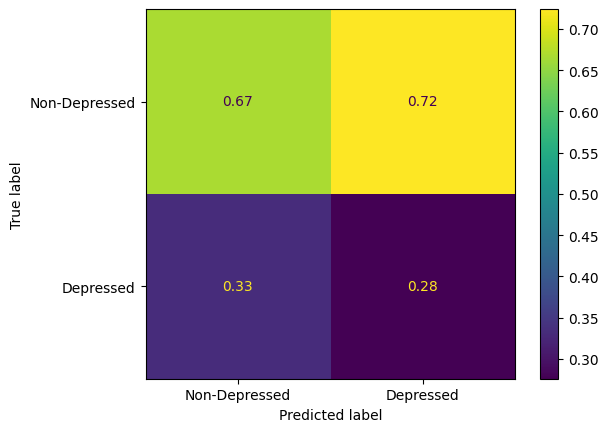

Accuracy = 0.471264367816092
Recall = 0.45283018867924524
Precision = 0.27586206896551724
F1-score = 0.3428571428571428


In [15]:
#Predict
x = AUs_test
y = y_test
# x = x_dev_bad
# y = y_dev_bad
y_AUs_prediction = model_AUs.predict(x)
y_AUs_prediction = np.argmax(y_AUs_prediction, axis = 1)
# print(sum(y_AUs_prediction)/len(y_AUs_prediction))
print(y_AUs_prediction)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y, y_AUs_prediction, normalize='pred')
print(result)
cm_display = ConfusionMatrixDisplay(confusion_matrix = result, display_labels = ["Non-Depressed", "Depressed"])
cm_display.plot()
plt.show()
tn_AUs = result[0][0]
tp_AUs = result[1][1]
fn_AUs = result[1][0]
fp_AUs = result[0][1]
accuracy = (tp_AUs + tn_AUs)/(tp_AUs + tn_AUs + fp_AUs + fn_AUs)
recall = tp_AUs / (tp_AUs + fn_AUs)
precision = tp_AUs / (tp_AUs + fp_AUs)
f1_score = 2 * precision * recall / (precision + recall)
print("Accuracy = " + str(accuracy))
print("Recall = " + str(recall))
print("Precision = " + str(precision))
print("F1-score = " + str(f1_score))

In [16]:
plot_model(model_AUs, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [17]:
# model_AUs.save("saved_models/good_AUs_21_6")